# Topics in Natural Language Processing 2019 - Assignment 1
### Dolav Nitay - 203598990

In [1]:
import nltk, re, pprint
import numpy as np
from nltk import word_tokenize,sent_tokenize,regexp_tokenize
from collections import Counter, defaultdict
from typing import List, Dict, Set, Callable, Tuple

## Part 1 - Language models

### 1.1.1 Gathering and cleaning up the data
We want to be able to clean up our data, before being able to perform any meaningful task on it, like language model creation. 
Let's have a look first on raw text, and see how it looks. Let's have a look on some of Shakespeare works.

In [213]:
text = open('shakespeare_input.txt').read()
print((text[:500]))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor


We need to tokenize our text first. We can use the sent_tokenize and word_tokenize methods from the nltk library to do that. The sent_tokenize method will split our text to a list of sentences, and then we'd be able to use to word_tokenize method on each sentence to split it to a list of word tokens.

In [214]:
sent_list = sent_tokenize(text)
for i, sent in enumerate(sent_list):
    sent_list[i] = word_tokenize(sent)

Let's now see how are text looks after tokenization, where every sentence is in a different line.

In [215]:
print('\n'.join([' '.join(sent) for sent in sent_list[:15]]))

First Citizen : Before we proceed any further , hear me speak .
All : Speak , speak .
First Citizen : You are all resolved rather to die than to famish ?
All : Resolved .
resolved .
First Citizen : First , you know Caius Marcius is chief enemy to the people .
All : We know't , we know't .
First Citizen : Let us kill him , and we 'll have corn at our own price .
Is't a verdict ?
All : No more talking o n't ; let it be done : away , away !
Second Citizen : One word , good citizens .
First Citizen : We are accounted poor citizens , the patricians good .
What authority surfeits on would relieve us : if they would yield us but the superfluity , while it were wholesome , we might guess they relieved us humanely ; but they think we are too dear : the leanness that afflicts us , the object of our misery , is as an inventory to particularise their abundance ; our sufferance is a gain to them Let us revenge this with our pikes , ere we become rakes : for the gods know I speak this in hunger for 

We can see that the tokenizer split we'll to we and 'll. But the tokenizer didn't split know't to know it, or know 't. Looks like the word tokenizer method of the nltk library is having a hard time with Shakespearean English. Let's now write methods for cleaning all punctuations from our text.
First, let's define some helper functions, to help us find out if a token is a number, and to clean all the punctuations from our data.

In [216]:
def removePunctuations(input: List[str]) -> List[str]:
    return list(filter(lambda word: word not in '()...,:--?!;\``\'\'', input))

Let's use this method on our tokenized text:

In [217]:
sent_list = [removePunctuations(sent) for sent in sent_list]
print('\n'.join([' '.join(sent) for sent in sent_list[:15]]))

First Citizen Before we proceed any further hear me speak
All Speak speak
First Citizen You are all resolved rather to die than to famish
All Resolved
resolved
First Citizen First you know Caius Marcius is chief enemy to the people
All We know't we know't
First Citizen Let us kill him and we 'll have corn at our own price
Is't a verdict
All No more talking o n't let it be done away away
Second Citizen One word good citizens
First Citizen We are accounted poor citizens the patricians good
What authority surfeits on would relieve us if they would yield us but the superfluity while it were wholesome we might guess they relieved us humanely but they think we are too dear the leanness that afflicts us the object of our misery is as an inventory to particularise their abundance our sufferance is a gain to them Let us revenge this with our pikes ere we become rakes for the gods know I speak this in hunger for bread not in thirst for revenge
Second Citizen Would you proceed especially against 

Before counting words, we want all our words in our data to be lower case, so not to count a word more than once by being case-sensitive.

In [218]:
sent_list = [[word.lower() for word in sent] for sent in sent_list]
print('\n'.join([' '.join(sent) for sent in sent_list[:15]]))

first citizen before we proceed any further hear me speak
all speak speak
first citizen you are all resolved rather to die than to famish
all resolved
resolved
first citizen first you know caius marcius is chief enemy to the people
all we know't we know't
first citizen let us kill him and we 'll have corn at our own price
is't a verdict
all no more talking o n't let it be done away away
second citizen one word good citizens
first citizen we are accounted poor citizens the patricians good
what authority surfeits on would relieve us if they would yield us but the superfluity while it were wholesome we might guess they relieved us humanely but they think we are too dear the leanness that afflicts us the object of our misery is as an inventory to particularise their abundance our sufferance is a gain to them let us revenge this with our pikes ere we become rakes for the gods know i speak this in hunger for bread not in thirst for revenge
second citizen would you proceed especially against 

That looks better. We also need to swap all numbers by the token N, let's do that. Even though there are no numbers in our Shakespearean texts.

In [219]:
def isNumber(input: str) -> bool:
    try:
        float(input)
        return True
    except ValueError:
        return False

In [220]:
for ind, sent in enumerate(sent_list):
    for w_ind, word in enumerate(sent_list[ind]):
        if isNumber(word):
            sent_list[ind][w_ind] = 'N'

We want to filter out all the least common words. Let's keep only the top 10000 words, and replace the rest with the token <unk>. For that, we can use the counter data structure.

In [221]:
wordsCounter = Counter()
for sent in sent_list:
    for word in sent:
        wordsCounter[word] = wordsCounter[word]+1

Let's see the 10 most common words.

In [222]:
wordsCounter.most_common(10)

[('the', 26187),
 ('and', 23521),
 ('i', 21761),
 ('to', 18100),
 ('of', 16359),
 ('you', 13739),
 ('a', 13479),
 ('my', 12001),
 ('that', 10868),
 ('in', 10304)]

Let's filter all the words that do not appear in the top 10000 most common words.

In [223]:
common_words = [w for w,occ in wordsCounter.most_common(10000)]
for ind,sent in enumerate(sent_list):
    for w_ind,word in enumerate(sent_list[ind]):
        if word not in common_words:
            sent_list[ind][w_ind] = '<unk>'

Let's have a look at the text again:

In [224]:
print('\n'.join([' '.join(sent) for sent in sent_list[:15]]))

first citizen before we proceed any further hear me speak
all speak speak
first citizen you are all resolved rather to die than to famish
all resolved
resolved
first citizen first you know caius marcius is chief enemy to the people
all we know't we know't
first citizen let us kill him and we 'll have corn at our own price
is't a verdict
all no more talking o n't let it be done away away
second citizen one word good citizens
first citizen we are accounted poor citizens the patricians good
what authority surfeits on would relieve us if they would yield us but the superfluity while it were wholesome we might guess they relieved us <unk> but they think we are too dear the leanness that <unk> us the object of our misery is as an inventory to <unk> their abundance our sufferance is a gain to them let us revenge this with our pikes ere we become <unk> for the gods know i speak this in hunger for bread not in thirst for revenge
second citizen would you proceed especially against caius marcius


We can see that "humanely" and a few other words weren't kept, and were filtered out.
Let's define a general function for doing everything we've done with our shakespearean texts.
We'll define the method ptb_preprocess, which given a list of files, does all the pre-processing we've mentioned before and outputs them in the ptb format.

In [275]:
def ptb_preprocess(filenames: List[str], top: int = 10000) -> None:
    for file_name in filenames:
        file = open(file_name, encoding='utf8', errors='ignore')
        text = '\n'.join(file)
        sentences = sent_tokenize(text)
        words = [word_tokenize(sentence) for sentence in sentences]
        c = Counter()
        for ind, sentence in enumerate(words):
            words[ind] = removePunctuations(words[ind])
            for w_ind, word in enumerate(words[ind]):
                words[ind][w_ind] = words[ind][w_ind].lower()
                if isNumber(word):
                    words[ind][w_ind] = 'N'
                word = words[ind][w_ind]
                c[word] = c[word]+1
        common_words = [w for w,occ in c.most_common(top)]
        for sent_ind, sent in enumerate(words):
            for word_ind, word in enumerate(sent):
                if word not in common_words:
                    words[sent_ind][word_ind] = '<unk>'
        output = open(file_name + '.out', 'w',encoding='utf8', errors='ignore')
        for sent in words:
            output.write(' '.join(sent))
            output.write('\n')
        output.close()



Let's run this method on a corpus of shakespearean texts, to test how well it works.

In [270]:
ptb_preprocess(["shakespeare_input.txt"])

Let's see how well it works.

In [271]:
r = open("shakespeare_input.txt.out").read().split()
print(' '.join(r[100:120]))

they would yield us but the superfluity while it were wholesome we might guess they relieved us <unk> but they


Let's try it now on the first Harry Potter book:

In [272]:
ptb_preprocess(["HarryPotter1.txt"])

In [278]:
r = open("HarryPotter1.txt.out", encoding='utf8').read().split()
print(' '.join(r[2530:2575]))

on the wall next to the cat he did n't look at it but after a moment he spoke to it fancy seeing you here professor mcgonagall he turned to smile at the tabby but it had gone instead he was smiling at a rather


We can see that our preprocessing removed qutoations and other punctuations, and also converted the entire text to lower case. Also we can observe tokenization of didn't to did and n't. The book doesn't have more than 10000 words (rather suprising) so we can't see the filtering of less common words, but we've already observed that with the shakespearean texts.
Let's try it again on a different book. This time, one that contains a number in it's title.

In [276]:
ptb_preprocess(['catch22.txt'])

In [280]:
r = open("catch22.txt.out", encoding='utf8').read().split()
print(' '.join(r[2530:2575]))

'of the fighting 256th squadron yossarian replied 'i did n't know there were any other captain yossarians as far as i know i 'm the only captain yossarian i know but that 's only as far as i know 'i see the chaplain said unhappily


We can see here a possible problem. Our preprocessing left the token 256th as it is, while perhaps we would have wanted to change it to the Nth.

### 1.1.2 Gathering basic statistics
Now, let's gather some basic statistics about our data. We'll use the Penn Tree Bank (PTB) dataset, which has been pre-processed to the format we used in part 1.1.1

In [5]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

We'll create a method for reading the ptb data. The method will return the data in an a dictionary, which will contain the list of all the words and characters in the dataset, for easy implementation of n-gram training, and also a list of all the sentences in the dataset. The method will also return a counter object for characters and words for statistics.

In [6]:
def read_data(name: str) -> Dict:
    words_data = open("ptb/ptb." + name + ".txt", "r", encoding="utf8").read()
    chars_data = open("ptb/ptb.char." + name + ".txt", "r", encoding="utf8").read()
    sentences_data = words_data.split('\n')
    sentences_data = [sentence.split() for sentence in sentences_data]
    words_tokens = words_data.split()
    chars_tokens = chars_data.split()
    words_counter = Counter(words_tokens)
    chars_counter = Counter(chars_tokens)
    words_set = set(words_tokens)
    return {'data': words_data, 'words': words_tokens, 'counter': words_counter, 'set': words_set,
           'sentences': sentences_data, 'chars': chars_tokens, 'char_counter': chars_counter}


Now, let's read the training, test and validation data.

In [7]:
training_data = read_data("train")
test_data = read_data("test")
validation_data = read_data("valid")

First, let's count the number of unique tokens, using the counter object. And the total number of tokens in the training set. Also, let's count the total number of characters in this set, so to count average number of characters per word, and the standard deviation.

In [13]:
print("Total number of words:",len(training_data['words']))
print("Unique number of words:",len(training_data['counter']))
print("Average occurences of unique tokens:", float(len(training_data['words'])/len(training_data['counter'])))
print("Total number of characters:",len(training_data['chars']))
print("Average length of each word:",np.average([len(word) for word in training_data['words']]))
print("Standard deviation of word's length:",np.std([len(word) for word in training_data['words']]))

Total number of words: 887521
Unique number of words: 9999
Average occurences of unique tokens: 88.76097609760976
Total number of characters: 4975414
Average length of each word: 4.653367075257938
Standard deviation of word's length: 2.6019161500774306


Now we'll write a function, that will give us the total number of tokens corresponding to the top-N tokens in the data.

In [14]:
def top_N_tokens(n: int, data: Dict) -> int:
    top_tokens = [word for word, count in data['counter'].most_common(n)]
    filtered_list = list(filter(lambda word: word in top_tokens, data['words']))
    return len(filtered_list)


And we'll test this function on our training data:

In [15]:
top_N_tokens(10, training_data)

251694

Now we'll see how much tokens are in the validation data, but not in the training data, using the set data structure of python.

In [16]:
len(validation_data['set']-training_data['set'])

0

That's good, all the tokens found in the validation data, also exist in the training data.

Now we'll create a function to count n-grams, in order to get statistics about them.

In [17]:
def count_n_grams(n: int, data: List[str]) -> Dict:
    n_gram_list = []
    for i in range(len(data)-n):
        n_gram_list.append(tuple(data[i:i+n]))
    n_gram_counter = Counter(n_gram_list)
    return {'list': n_gram_list, 'counter': n_gram_counter}


Now let's count the number of distinct n-grams of characters and words in our data.

In [18]:
for i in range(2,8):
    c = count_n_grams(i, training_data['words'])['counter']
    c2 = count_n_grams(i, training_data['chars'])['counter']
    print("Number of distinct words {:d}-grams is {:d}".format(i, len(c)))
    print("Number of distinct characters {:d}-grams is {:d}".format(i, len(c2)))

Number of distinct words 2-grams is 277477
Number of distinct characters 2-grams is 958
Number of distinct words 3-grams is 615618
Number of distinct characters 3-grams is 9418
Number of distinct words 4-grams is 771492
Number of distinct characters 4-grams is 48379
Number of distinct words 5-grams is 825370
Number of distinct characters 5-grams is 154572
Number of distinct words 6-grams is 846671
Number of distinct characters 6-grams is 369781
Number of distinct words 7-grams is 856939
Number of distinct characters 7-grams is 703050


We expect the word count distribution to follow power law distributions, which means the the plot of the log-distribution and the log-rang would be almost linear.

Text(0,0.5,'frequency')

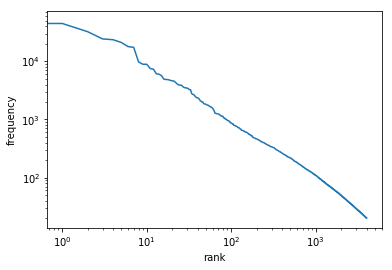

In [286]:
plt.loglog([val for word,val in training_data['counter'].most_common(4000)])
plt.xlabel('rank')
plt.ylabel('frequency')

It appears that the Penn Treebank dataset follow power law distribution, as the log log plot is almost linear.

### 1.2 $n$-gram word language model
We'll now create an usmotheed maximum likelihood word level language level. The data structure we would use is a dictionary of dictionaries. Our top level dictionary will contain a mapping from ngrams to a distribution function of the words following that n-gram. That distribution function would be a dictionary itself, and would map from words to probabilities.

We'll attempt two methods of training our language model. In the first, we'll look on each sentence as a distinct unit, and we'll train our language model on all sentences. And in the second method, we'll treat our entire corpus as one big sentence. We'll see which method gives us better perplexity.

In [287]:
from nltk.probability import FreqDist, LidstoneProbDist, MLEProbDist, ProbDistI

def train_word_lm1(dataset: List[str], n: int = 2) -> Dict:
    prob_map = defaultdict(FreqDist)
    dataset = ['*']*n + dataset
    for i in range(n, len(dataset)):
        word, ngram = dataset[i], tuple(dataset[i-n:i])
        prob_map[ngram][word] = prob_map[ngram][word]+1
    return prob_map

def train_word_lm2(dataset: List[List[str]], n: int = 2) -> Dict:
    prob_map = defaultdict(FreqDist)
    for sentence in dataset:
        sentence = ['*']*n + sentence +['~']*n
        for i in range(n, len(sentence)):
            word, ngram = sentence[i], tuple(sentence[i-n:i])
            prob_map[ngram][word] = prob_map[ngram][word]+1
    return prob_map
FIRST_N = 1
LAST_N = 11
vocab_len = len(training_data['counter'])

In [21]:
models1 = [train_word_lm1(training_data['words'],i) for i in range(FIRST_N, LAST_N)]
models2 = [train_word_lm2(training_data['sentences'],i) for i in range(FIRST_N,LAST_N)]

### 1.3 Language model evaluation
After creating our language model we can check how good it is using perplexity. But before we can do that, we must use smoothing on our model. Why? Right now if an $n$-gram didn't occour at all in our training set, it's probability will be 0, and we wouldn't be able to calculate the perplexity. One such smoothing method is the Lidstone smoothing method, in which we add $\gamma$  ($0<\gamma\leq 1$) to the count of each event (Both seen and unseen events). 
We'll measure the perplexity of both our models for different value of $n$ and $\gamma$, and use these tests to decide which model to use and with which parameters.

In [22]:
from math import log

def get_entropy1(dataset: List[str], prob_funcs: List[Dict], gamma: float = 0, n: int=2) -> float:
    dataset = ['*']*n + dataset
    ans = 0
    prob_func = prob_funcs[n-FIRST_N]
    if n==0:
        return -log(1/float(vocab_len), 2)
    for i in range(n, len(dataset)):
        word, ngram = dataset[i], tuple(dataset[i-n:i])
        p = LidstoneProbDist(prob_func[ngram], gamma, bins=vocab_len)
        ans = ans + log(p.prob(word), 2)
    return -ans/(len(dataset)-n+1)

def get_entropy2(dataset: List[List[str]], prob_funcs: List[Dict], gamma: float = 0, n: int=2) -> float:
    ans = 0
    total = 0
    prob_func = prob_funcs[n-FIRST_N]
    if n==0:
        return -log(1/float(vocab_len), 2)
    for sentence in dataset:
        sentence = ['*']*n + sentence + ['~']*n
        for i in range(n, len(sentence)):
            word, ngram = sentence[i], tuple(sentence[i-n:i])
            p = LidstoneProbDist(prob_func[ngram], gamma, bins=vocab_len)
            ans = ans + log(p.prob(word), 2)
            total = total+1
    return -ans/(total)


def get_perplexity1(dataset: List[str], prob_funcs: List[Dict], gamma: int = 1, n: int=FIRST_N) -> float:
    return 2**get_entropy1(dataset, prob_funcs, gamma, n)

def get_perplexity2(dataset: List[List[str]], prob_funcs: List[Dict], gamma: int = 1, n: int=FIRST_N) -> float:
    return 2**get_entropy2(dataset, prob_funcs, gamma, n)



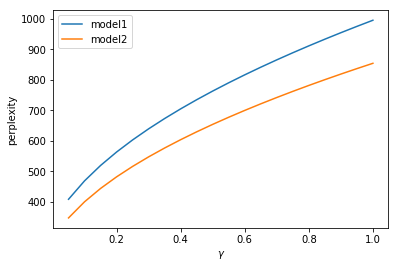

In [23]:
gammas = [(i+1)/20 for i in range(20)]

perplexities1 = [get_perplexity1(validation_data['words'], models1, gamma=i) for i in gammas]
perplexities2 = [get_perplexity2(validation_data['sentences'], models2, gamma=i) for i in gammas]
plt.xlabel('$\gamma$')
plt.ylabel('perplexity')
plt.plot(gammas, perplexities1)
plt.plot(gammas, perplexities2)
plt.legend(['model1','model2'])


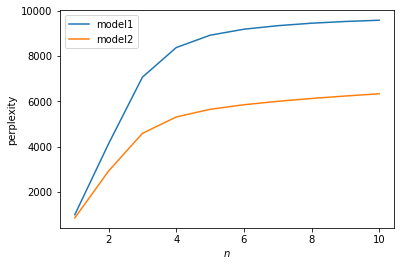

In [24]:
ns = range(FIRST_N,LAST_N)

perplexities1 = [get_perplexity1(validation_data['words'], models1, n=i) for i in ns]
perplexities2 = [get_perplexity2(validation_data['sentences'], models2, n=i) for i in ns]
plt.xlabel('$n$')
plt.ylabel('perplexity')
plt.plot(ns, perplexities1)
plt.plot(ns, perplexities2)
plt.legend(['model1', 'model2'])


Let's see what is the perplexity for a model which picks the next word in a uniform distribution:

In [25]:
get_perplexity1(validation_data['words'],models1,n=0)

9998.999999999998

The perplexity is $|V|$ as expected. (Where $|V|$ is the size of our vocabulary)

Also we can observe that the second model has a better perplexity than the first, for all values of $\gamma$ and $n$. That is - if we treat every sentence as a different unit, we'll get better results. This is probably because each word depend less on words from different sentences. For large values of $n$ the difference becomes larger, probably because many sentences doesn't contain that much tokens, but we can see that even for smaller values of $n$ our second model performs better. 
The fact that the perplexity grows with n is suprising, as remembering more history should enhance our model's performance. I believe that this is due to the fact that the n-gram model can't generalize. For larger values of $n$ most n-grams that we encountered in the training data won't be seen in the validation data.


### 1.3.2 Text generation
A better way perhaps to test our model, is to let it generate sentences.
We'll create a method for a generation of sentence according to our language model, and we'll use it to generate a fixed amount of sentences. A generation of each sentence will end when the sentence end symbol will be generated. (We'll also set a maximum sentence length to avoid infinite loops if those should occur).

Let's start with the models which gave us the best results. That is, $n=2$, and $\gamma=0.1$, and see what sentences they generate. We'll generate each time the most probable the word to appear after the given n-gram.

In [26]:
SENTENCES_NUM = 5
MAX_WORD_IN_SENTENCE = 20
models = models2

def generate_word_max(ngram: Tuple[str], n: int, gamma: float) -> str:
    model_ind = n-FIRST_N
    model = models[model_ind]
    if(len(ngram)>model_ind+FIRST_N):
        ngram = ngram[-n:]
    if(len(ngram)<model_ind+FIRST_N):
        ngram = ['*']*(n-len(ngram))+ngram
    app_n_gram = ngram
    app_model = model
    curr_ind = model_ind
    while len(app_model[tuple(app_n_gram)])==0: #n-gram doesn't appear in our training data
        curr_ind = curr_ind - 1
        app_model = models[curr_ind]
        app_n_gram = app_n_gram[1:]
    p = LidstoneProbDist(app_model[tuple(app_n_gram)], gamma, bins=vocab_len)
    return p.max(), ngram

def generate_sentence(model: Callable[[Tuple[str]],str], seed: str) -> str:
    ans = ""
    curr_n_gram = seed.split()
    while(len(ans.split())<MAX_WORD_IN_SENTENCE):
        next_word, curr_n_gram = model(curr_n_gram)
        if next_word == '~':
            return ans
        curr_n_gram = curr_n_gram[1:] + [next_word]
        ans = ans + " " + next_word
    return ans

def generate(model: Dict, seed: str) -> str:
    ans = seed
    for i in range(SENTENCES_NUM):
        sent = generate_sentence(model, seed) + '\n'
        seed = ''
        ans = ans + sent
    return ans


In [27]:
print(generate(lambda a: generate_word_max(a, 2, 0.1), "why"))

why should i be part of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of
 the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk>
 the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk>
 the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk>
 the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk> of the <unk>



That's not very good, we generated the same sentence over and over again. Let's try now to pick not the most probable word, but rather to pick each word in the probability in which it occurs in the training data after the given n-gram.

In [32]:
def generate_word_prob(ngram: Tuple[str], n: int, gamma: float) -> str:
    model_ind = n-FIRST_N
    model = models[model_ind]
    if(len(ngram)>model_ind+FIRST_N):
        ngram = ngram[-n:]
    if(len(ngram)<model_ind+FIRST_N):
        ngram = ['*']*(n-len(ngram))+ngram
    app_n_gram = ngram
    app_model = model
    curr_ind = model_ind
    while len(app_model[tuple(app_n_gram)])==0: #n-gram doesn't appear in our training data
        curr_ind = curr_ind - 1
        app_model = models[curr_ind]
        app_n_gram = app_n_gram[1:]
    p = LidstoneProbDist(app_model[tuple(app_n_gram)], gamma, bins=vocab_len)
    return p.generate(), ngram


Let's start like before with $n=2$ and $\gamma=0.1$ , and see what results we are getting.

In [33]:
print(generate(lambda a: generate_word_prob(a, 2, 0.1), "why"))

why was <unk> his local congressman and former u.s. intelligence mr. noriega but merely sought to turn over foreign documents could
 a tvs spokesman said yesterday a recent white house got the better business bureau in late june
 in early march
 they believe technology is so pessimistic
 in his chair mr. straszheim is <unk> because its card business



We don't receive the same sentence over and over again, but the sentences themselves don't make much sense. Let's try a higher value of $n=5$.

In [34]:
print(generate(lambda a: generate_word_prob(a, 5, 0.1), "the new"))

the new argument over the notification guideline however could sour any atmosphere of cooperation that existed
 senate <unk> final arguments in impeachment trial of federal judge
 whitbread 's wine spirits and soft-drink operations had trading profit of # N million a gain it attributes to higher
 personal spending which fueled the economy 's growth in the third quarter slowed to about N N from the second
 this test was the first to predict <unk> whether an individual could expect to develop cancer



That's better. Let's try a higher value of $n=7$, and see what results we are getting.

In [35]:
print(generate(lambda a: generate_word_prob(a, 7, 0.1), "the new"))

the new services allow u.s. trust to cater to the new wealth mr. schwarz says
 but whitbread has been squeezed by giant rivals amid widespread consolidation in the industry
 market participants hope today 's gnp report will offer more substantial evidence on u.s. economic growth although analysts are quick
 he discovered a <unk> <unk> in the charges made to various departments for computer time and <unk> it to a
 for these workers at the bottom of the mine 's pay scale this is usually enough to overcome the temptation



The sentences themselves make sense, but there isn't any connection between each individual sentence, nor we expect a connection to be, because we are using the second model which handles each sentence as a different unit. Let's try generating a text with the first model. This time will limit the number of words to 100, instead of putting a limit on the number of sentences.
Let's first update our generate model, to generate text, instead of generating a sequence of sentences.

In [36]:
OUTPUT_LEN = 100

def generate(model: Callable[[Tuple[str]],Tuple[str, Tuple[str]]], seed: str) -> str:
    ans = seed
    curr_n_gram = seed.split()
    for i in range(OUTPUT_LEN):
        next_word, curr_n_gram = model(curr_n_gram)
        curr_n_gram = curr_n_gram[1:] + [next_word]
        ans = ans + " " + next_word
    return ans

Also, we need to use our first set of models.

In [530]:
models = models1

Let's try to generate text now, using our new generate method.

In [531]:
print(generate(lambda a: generate_word_max(a, 3, 0.1), "we believe we"))

we believe we have to <unk> the <unk> of the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


Again, since we're picking the most probable word, we're stuck in a loop. Let's try a higher value of $n$.

In [301]:
print(generate(lambda a: generate_word_max(a, 5, 0.1), "we believe we"))

we believe we have to take a shot at getting as much done as we can through the court through justice and through state and federal regulatory agencies i see congress as a last resort healthy thrifts such as columbia or the junk-bond market itself should have been so lucky the reality of life in modern america is that if you want to <unk> something that works let it fall into the hands of congress exxon corp. said it will move its headquarters from manhattan to dallas most of the N employees at the oil company 's <unk> headquarters building including much of


That's actually quite good. It seems that for text generation it's better to handle the entire text as one unit, instead of splitting it to sentences. Let's try a higher value of $n$. And a different seed.

In [305]:
print(generate(lambda a: generate_word_max(a, 7, 0.1), "the new york"))

the new york stock exchange composite index fell N to N most of last week 's surge in the industrial average came on monday when the average rose N points as market players snapped up blue-chip issues and <unk> the broad market that contrast was reflected in the smaller weekly percentage gains recorded by the broader averages the s&p N rose N N the dow jones equity market index added N to N and the new york stock exchange composite index fell N to N most of last week 's surge in the industrial average came on monday when the average rose N


Let's introduce now a new parameter to our model, called the temperature. We will mark the temperature by $\tau$.  The temperature affects the model by being a parameter to a "freezing function", which will alter our probability model. The freezing function is defined as follows: 
$f_{\tau}(p_{i})=\frac{p_{i}^{\frac{1}{\tau}}}{\sum_{j} p_{j}^{\frac{1}{\tau}}}$
One can observe that for $\tau=1$, the freezing function is the identity function. As we lower the value of $\tau$, the freezing function makes the likely outcomes more likely, and less likely outcomes less likely. It makes our model more conservetive, and more likely to pick a next word with very high probability. For $\tau\rightarrow 0$, we receive that our freezing function is simply the argmax function, and will pick always the most likely outcome.

We'll define our TemperatureProb class, which will inherit from ProbDistI. This distribution will receive the temperature parameter, and the original distribution in it's constructor, and will calculate the value $\sum_{j} p_{j}^{\frac{1}{\tau}}$ during construction. Then the prob method, will calculate the value $p_{i}^{\frac{1}{\tau}}$, and will divide it by the pre-calculated value.

In [306]:
class TemperatureProb(ProbDistI):
    SUM_TO_ONE = False
    def __init__(self, origDist, temperature):
        self._origDist = origDist
        self._temperature = float(temperature)
        self._deviator = 0
        for sample in self._origDist.samples():
            p = self._origDist.prob(sample)**(1/self._temperature)
            self._deviator = self._deviator + p


    def freqdist(self):
        """
        Return the frequency distribution that this probability
        distribution is based on.

        :rtype: FreqDist
        """
        return self._origDist



    def prob(self, sample):
        c = (self._origDist.prob(sample)**(1/self._temperature))/(self._deviator)
        return c



    def max(self):
        # The maximum remains the same as in the original distribution
        return self._origDist.max()



    def samples(self):
        return self._origDist.samples()


    def __repr__(self):
        """
        Return a string representation of this ``ProbDist``.

        :rtype: str
        """
        return '<TempeatureProbability temp={0}>'.format(self._temperature)

The code works the same like the code of Sameer Sing in generator.py. Only where we use the original distribution methods of generation and only alter the probability, Sameer implemented the generate method from scratch. He choose to work with log probabilities (A smarter choice to avoid floating points problems I suppose), he calculates the new probabilities for all the words using the freezing function. Since $log(a^{b})=b\cdot log(a)$, he can calculate the numerator by $\frac{1}{\tau}\cdot log(p_{i})$. He also calculates the sum of all the probabilities using this method and the method logaddexp2 of numpy, which returns for two given numbers $a$ and $b$ the value $log_{2}(2^{a}+2^{b})$.

We'll also create a new generate_word_temp function, which will be used by our generate method to generate the next word using our new distribution.

In [310]:
def generate_word_temp(ngram: Tuple[str], n: int, gamma: float, temp: float) -> str:
    model_ind = n-FIRST_N
    model = models[model_ind]
    if(len(ngram)>model_ind+FIRST_N):
        ngram = ngram[-n:]
    if(len(ngram)<model_ind+FIRST_N):
        ngram = ['*']*(n-len(ngram))+ngram
    app_n_gram = ngram
    app_model = model
    curr_ind = model_ind
    while len(app_model[tuple(app_n_gram)])==0: #n-gram doesn't appear in our training data
        curr_ind = curr_ind - 1
        app_model = models[curr_ind]
        app_n_gram = app_n_gram[1:]
    p = LidstoneProbDist(app_model[tuple(app_n_gram)], gamma, bins=vocab_len)
    p1 = TemperatureProb(p, temp)
    return p1.generate(), ngram

For sanity, let's pick a value $\tau\rightarrow 0$, and see if we get the same output we did when picking always the most likely word.

In [477]:
print(generate(lambda a: generate_word_temp(a, n=3, gamma=0.1, temp=0.01), "we believe we"))

we believe we have to <unk> the <unk> of the <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk> <unk>


Now let's try to increase our temperature and make our model less conservative. Let's try $\tau=0.5$.

In [478]:
print(generate(lambda a: generate_word_temp(a, n=3, gamma=0.1, temp=0.5), "we believe we"))

we believe we have to clear up order backlogs in france more than half the level traditionally considered desirable mr. <unk> who is a convicted <unk> through a vast retail network in recent years and in enabling the company 's <unk> group u.s. trust a <unk> institution that is one of the most powerful <unk> in the <unk> and <unk> the <unk> and <unk> <unk> the <unk> of <unk> and <unk> <unk> the lucky ones <unk> out at the same time he began building up the <unk> themselves were <unk> low <unk> <unk> consumers who wanted big houses mercedes cars beautiful women expensive


### 1.4 Character language model
In this part we will work on a character level language model.

#### 1.4.1. Summaries of the two articles

####  The Unreasonable Effectiveness of Recurrent Neural Networks
In this article, Andrej Karpathy introdouces us to the model of RNN(Recurrent Neural Networks). In this model, the neural network accepts a sequence of vectors as an input, rather than a single vector, and also outputs a sequence of vectors. The RNN works by accepting a single vector every time, but the output is influenced not only by that vector, but also by the entire history of vectors that were inputted prior to that vector. In his article Andrej trained his model on a few examples. Some basic examples like Shakespear texts, on which we saw that a basic n-gram model could perform nicely. But the more suprising examples were how the RNN learned advanced syntax in his examples. For example, the RNN was trained on an algebra book written in latex format, and could create his own latex book, which almost compiled. He was also trained on the linux' kernel code, in which the RNN learned how to properly indent his code, and also learned how to open and close his brackets properly. (Which would require a long history to remember in an n-gram model). Another suprising finding was seeing how some neurons in the RNN were adjusted to learning specific tasks. For example, a specific neuron tuned itself to keeping track when inside and outside of comments in c code, or another neuron tuned itself to keep track when in if statements. Those kind of abilities couldn't be achieved with a normal n-gram model.

#### The unreasonable effectiveness of Character-level Language Models (and why RNNs are still cool)
In this article, Yoav Goldberg shows us how a simple n-gram based model, which picks the next character based on the maximum likelihood, could also achieve quite suprising results. He shows that by training the model on Shakespeare texts, the model was able to generate some quite believable texts, which were written in a syntactically correct english. These results were achieved using quite a small value of n, between 7 and 10. However, Yoav's model wasn't able to learn the syntax of the linux' kernel code like Andrej model did. This is even for larger values of n. I believe that suprising results of Yoav's model on Shakespeare's texts, were because the syntax of english is quite easy to learn in an n-gram model. There are no really long range dependencies, so with remembering a short history of 7-10 letters you are able to predict quite well the next character. However, for a programming language, in which there are much more long range dependencies in the syntax, an n-gram model isn't good enough.

#### 1.4.1.2 Dataset reader
We'll now create a method for extracting the recipes data. The method will read all the files in the cooking directory (which contains the recipes). And divide the text into a list of recipes. (Recipes are divided in the text by a special delimiter)

In [8]:
import os

DIR_NAME = "cooking"
RECIPE_START = "MMMMM-----"
RECIPE_END = "MMMMM"

def recipe_reader() -> List[str]:
    files_list = os.listdir(DIR_NAME)
    recipes_list = []
    curr_recipe = ''
    for file in files_list:
        path = DIR_NAME + '/' + file
        text = open(path, encoding='utf-8').read().split('\n')
        for line in text:
            if RECIPE_START in line:
                continue
            if RECIPE_END in line:
                recipes_list.append(curr_recipe)
                curr_recipe = ''
                continue
            curr_recipe = curr_recipe.lower() + line + '\n'
    return recipes_list

recipes_list = recipe_reader()
recipes_tokenized = [removePunctuations(word_tokenize(recipe)) for recipe in recipes_list]

#### 1.4.1.3 Basic statistics
Let's gather some basic statistics about our data

In [9]:
lengthsCounter = Counter([len(recipe) for recipe in recipes_list])
numOfWordsCounter = Counter([len(recipe) for recipe in recipes_tokenized])
wordsCounter = Counter()
wordsLengthCounter = Counter()
charCounter = Counter()
for recipe in recipes_tokenized:
    for word in recipe:
        wordsCounter[word] = wordsCounter[word] + 1
        wordsLengthCounter[len(word)] = wordsLengthCounter[len(word)]+1
for recipe in recipes_list:
    for char in recipe:
        charCounter[char] = charCounter[char] + 1

First, the number of recipes:

In [10]:
len(recipes_list)

32965

The total number of characters:

In [11]:
sum([len(recipe) for recipe in recipes_list])

35960542

The total number of tokens in our recipes:

In [12]:
sum([len(recipe) for recipe in recipes_tokenized])

5733825

The size of our vocabulary:

In [13]:
len(wordsCounter.most_common())

70452

The number of distinct characters in our data:

In [14]:
CHAR_NUM = len(charCounter.most_common())
CHAR_NUM

132

Some histograms detailing the distribution of number of characters in each recipe, number of words in each recipe, and word length.

<BarContainer object of 2939 artists>

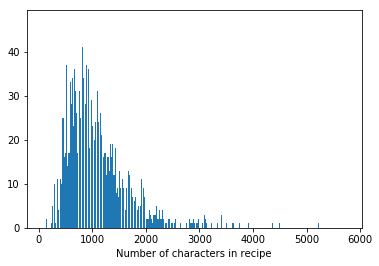

In [15]:
plt.xlabel("Number of characters in recipe")
plt.bar([tup[0] for tup in lengthsCounter.most_common()], [tup[1] for tup in lengthsCounter.most_common()])

<BarContainer object of 713 artists>

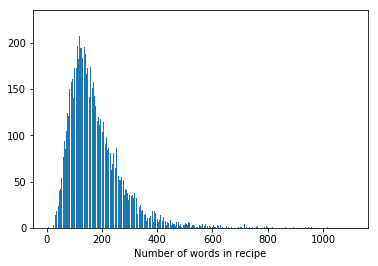

In [16]:
plt.xlabel("Number of words in recipe")
plt.bar([tup[0] for tup in numOfWordsCounter.most_common()], [tup[1] for tup in numOfWordsCounter.most_common()])

<BarContainer object of 53 artists>

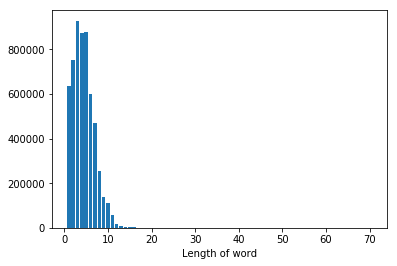

In [17]:
plt.xlabel("Length of word")
plt.bar([tup[0] for tup in wordsLengthCounter.most_common()], [tup[1] for tup in wordsLengthCounter.most_common()])

#### 1.4.1.4 Splitting the data
We'll now split the data into a training data which will consist 80% of the recipes, and test and dev data which will consist of 10% of the recipes each.

In [18]:
train_recipes = recipes_list[:(int)(0.8*len(recipes_list))]
test_recipes = recipes_list[(int)(0.8*len(recipes_list)):(int)(0.9*len(recipes_list))]
dev_recipes = recipes_list[(int)(0.9*len(recipes_list)):]

We'll train our model on the training data, with the same value of $n$ that were used in Yoav's article.

#### 1.4.1.5 Training the model
We'll train our model on different values of $n$, and measure the perplexity of the model for each.

Like in the word level model, we'll need smoothing for measuring perplexity, we'll use again Lidstone smoothing, with a small value of $\gamma=0.1$.

In [19]:
GAMMA = 0.1
FINAL_CHAR = '~'
def train_char_lm(dataset: str, prob_map: Dict, n: int = 4) -> None:
    dataset = '*'*n + dataset + FINAL_CHAR*n
    for i in range(n, len(dataset)):
        char, ngram = dataset[i], tuple(dataset[i-n:i])
        prob_map[ngram][char] = prob_map[ngram][char]+1

def get_prob_map(order: int) -> Dict:
    freq_dist = defaultdict(FreqDist)
    for recipe in train_recipes:
        train_char_lm(recipe, freq_dist, order)
    prob_map = defaultdict(LidstoneProbDist)
    for key in freq_dist:
        prob_map[key] = LidstoneProbDist(freq_dist[key], GAMMA, bins=CHAR_NUM)
    return prob_map

Let's create a method for measuring perplexity and entropy

In [20]:
def get_entropy(dataset: List[str], prob_func: Dict, n: int=2) -> float:
    ans = 0
    divisor = 0
    for recipe in dataset:
        recipe = '*'*n + recipe + '~'*n
        for i in range(n, len(recipe)):
            divisor = divisor + 1
            char, ngram = recipe[i], tuple(recipe[i-n:i])
            if ngram not in prob_func:
                p = LidstoneProbDist(FreqDist(), GAMMA, bins=CHAR_NUM)
            else:
                p = prob_func[ngram]
            ans = ans + log(p.prob(char), 2)
    return -ans/(divisor)

def get_perplexity(dataset: List[str], prob_func: Dict, n: int=FIRST_N) -> float:
    return 2**get_entropy(dataset, prob_func, n)

Let's measure the perplexity for a few values of $n$. 

In [31]:
orders = [2, 5, 7, 10, 15]

perplexities_gen = (get_perplexity(test_recipes, get_prob_map(order), order) for order in orders)
perplexities = []
for p in perplexities_gen:
    perplexities.append(p)

Let's measure the perplexity of the model using the test data

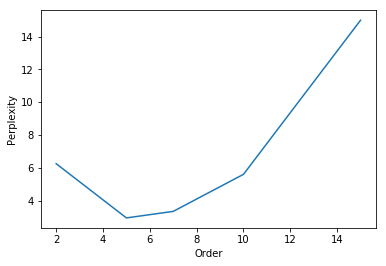

In [32]:
plt.xlabel("Order")
plt.ylabel("Perplexity")
plt.plot(orders, perplexities)

We can see that the perplexity reaches a minimum for $n=5$, but then rises again. This is probably due to the fact that for a larger value of $n$, more unseen $n$-grams are encountered in the test data. Maybe we should try to test our model by trying to generate recipes.
We'll set an upper bound of 10000 characters per recipe, but the generation will stop if the final char (~) will be generated.

In [38]:
def generate(model: Dict, n: int) -> str:
    ans = ""
    curr_n_gram = ['*' for c in range(n)]
    next_char = ''
    while True:
        next_char = model[tuple(curr_n_gram)].generate()
        if next_char == FINAL_CHAR:
            break
        curr_n_gram = curr_n_gram[1:] + [next_char]
        ans = ans + next_char
        if(len(ans)>10000):
            break
    return ans

Let's try first for $n=2$.

In [33]:
prob_map = get_prob_map(2)

In [39]:
print(generate(prob_map, 2))

 
   2 colls ticincy, 1/8 of
    ch fins, che gre
      brue late: emi the flought reppeparm
  
      1/4 c   1   2 to ans whighly eam
  by in juic
   careginkles: 6 of sup ming sp to 1 i set; mell, whiong ads and phiser jame staspred fringrecesp maing subbs. sy
        ch 1 sum slicke cate real, but untirstainacke caten
  1/4 thicken cove wref foremakind surecove * 
  a let, an
  3/4 tithend a sugarbonings, caken toser a maring well. and salmoveraigh. caken wat eggs
         shlembintill ornsalt. on cakervintir to af buts chisinly tabluffinallorscon.
  1 ore cablicke mil, soyce c witly 3/4 spie donamon flotte boarielourfachishen tocoth 1 cups
  md whocoono; 2. matowdeney hallan as sty mixtut. sm skintly parven cupeake reefortion wils theachaten forinedijoy    1 lenton the ightly dinkless alohoter
   1 ther ts thelling the eges. min and fly toppladd c & vand inutted caked flategol, ine to ad phant tonith a he gar asin., or vine
     grotack.
  garrickposs staboup itto 2 catervinairligh

This doesn't look like english at all, although we can see that the model adds quantities to the "recipe", and some words actually occur in this recipe, like "servings". Remembering just the last two letters is not enough, let's try $n=5$

In [40]:
prob_map = get_prob_map(5)
print(generate(prob_map, 5))

 
 
         1    bring constant each pie plate.
  
  yield: 1 servings
 
                      -and chocolate
     garlic in hot
         1 ts dark soy sauces
     1/2 inch chopped
      5 c  honey gives and cover chicken bread and set the boiler. cut into a saucepan with seasoning. he
  before sugar
     4 oz cans prunes,
  saute onions.  stiff. blanchego, sugar
    1    eggs, 17 mg
  cook till
  smooth.
  beat you will notes:
        1 c  butter, then it is tender. simmer for fruit proportions:
  
  juices from
  tender at roll out of the starch
  squash; cook til coat.place 1 lb)
 
      2 ts salt
  butter. place on soup)
 categories: cake-molasses at 350 degree over and abbott
    3 c  cointredients and vanilla extract. drain, remove paprika
 
      4    eggs, beaten
      dried and
  saute, peel, cinnamon and white size pulses, ends dill weed, splinterview, june 1996 205157
  


With remembering only five letters, our model already writes real english words, but this still doesn't look like a recipe. Let's try $n=7$

In [43]:
prob_map = get_prob_map(7)

In [46]:
print(generate(prob_map, 7))

 
 
      title: food sotres, or until
  mixture cupcake; place dough into chocolate syrup
    1/2 ts salt
      yield: 375 ml cognac
      3    granny smith]
      title: hidden by karen mintzias
 



That's not much better. Although the recipe started with "title", it included two titles. Also we can see an out of place closing brackets. Let's try $n=10$

In [47]:
prob_map = get_prob_map(10)

In [51]:
print(generate(prob_map, 10))

 
 
      title: apricot rum cake
 categories: desserts, pies, soup/stews, ireland, even just across the topping
    1/2 c  sugar (granulated sugar
      1 c  bulgur (i usually do it opposite side of a food
    1/4 ts hot pepper sauce into medium heat, add 1/2 teaspoons of the oil. process,
  while heating the ingredients
      4 tb vinegar, sugar,
  half/half
      5 ts sesame oil
 
  *    use tablespoon of the cooked
               ground crawfish fat; from the heat until juices run clear and thickenes too much. let me know if you want to
  try to plan to store liqueur
     12 oz monterey jack cheese
           baked pastry.
 



That looks a bit better. The recipe starts with a title, then there's the category to which this recipe belongs, a list of ingridients, and some instructions. We still can see here that the model opens brackets without closing them, but we already know that it's almost impossible to learn with a normal n-gram model, as the distance between the opening and closing brackets is unbounded. Let's try $n=15$ and see some more recipes generated.

In [52]:
prob_map = get_prob_map(15)

In [54]:
print(generate(prob_map, 15))

 
 
      title: chicken & wild rice saute
 categories: pasta, vegetarian, stews
      yield: 6 servings
 
      6 lb corned beef, thinly sliced
    1/2 c  milk
 
  cream together all items except the whipping cream
           -of orange peel
       -or- 2 ts soaked and coarsely chopped spinach
     14 oz can evaporated milk, cream of coconut
       12 oz pk semisweet chocolate; condensed milk
     13 oz canned water chestnuts
           -- coarsely grate chocolate
  
    be sure that the meat will double in volume, so make sure that
  there is enough
  syrup.
  
  high pectin fruits: strawberries,
  etc., then with a dollop of roasted peppers, leaving stems on.  cut small slice off back of each egg half so egg sits flat. place
  eggs on ham for eyes. lay pickle slices on ham for mouth. cut pimento
  in thin slices. using 1 tablespoonful
  of jam in the center. immediately use
  mixer at medium-high speed, using a whisk, combine the
  cranberries begin to release their
  juices. sprink

The recipe starts well enough, but very soon we see that although individual sentences make sense, the recipe itself doesn't. The title states that this is a recipe for chicken & wild rice saute, but that it's a vegetarian meal. Also there's no rice in the ingredients, only beef and milk. And the instructions don't make sense as well. Let's try to generate a different recipe.

In [55]:
print(generate(prob_map, 15))

 
 
      title: garlic


Well, I guess that you could call that a recipe. If only it included ingredients.

In [58]:
print(generate(prob_map, 15))

 
 
      title: crawfish bread
 categories: breads, cakes, desserts, bundt
      yield: 1 servings
 
           -bars (1.55 oz. each)
      2 cn ranch beans
    1/2 c  finely chopped
    1/2 c  carrot, chopped (i used 2, i
           used 2 jalapenos]
    1/4 ts cayenne or to taste
 
  * ancho or pasilla chilies) are sweet and plentiful. and the addition of numerous toppings. diners always seem
  to be impressed. bread is lightly toasted
    3/4 c  finely chopped. then add the apples and invert onto dish. to
  double recipe, make it twice. for individuals to add to the
  skillet. add the 2 teaspoons sugar, onions, oil, the
  salt, pepper and fresh parmesan
      1 ts parsley -- finely chopped gingerroot
  until combined, and they are certain to
  want more! pat empson 05/25 09:57 am
         food and wine bulletin board.
 



There's a title to the recipe, an ingredients list, and instructions. There isn't much connection between each part, and we can see again that the model doesn't use brackets correctly. 

The main observation I was able to make about those generated recipes, is that an $n$-gram model can't learn long-term connections in the text. But it still suprisingly learned the general syntax of a recipe - start with a title, then an ingredients list, then instructions, it even adds sometimes the source from which the recipe was taken, like in the training data. The recipes doesn't make sense, the model just generates the next character based on the last 15 characters, so we can't expect it to know very much about cooking, or the meaning of the word it uses.

## Part 2 - Polynomial curve fitting

### 2.1. Synthetic dataset generation

We'll implement the function generateDataset, which given an integer $n$, a function $f$, and a value of $\sigma$, will generate a dataset $D$ of $n$ points, such that $D=\{(x_{i},f(x_{i})+\varepsilon(x_{i}))|x_{i}=\frac{i-1}{n-1},1\leq i\leq n\}$ and $\varepsilon\sim N(0,\sigma^2)$.

In [88]:
def generateDataset(N: int, f: Callable[[float], float], sigma: float) -> Tuple[np.array]:
    x = np.linspace(0, 1, num=N)
    t = [f(i) + np.random.normal(loc=0.0, scale=sigma) for i in x]
    return x, t


Let's use our fucntion to generate a dataset of 100 points. Our function will be $f(x)=sin(2\pi x)$, and we'll use $\sigma=0.03$.

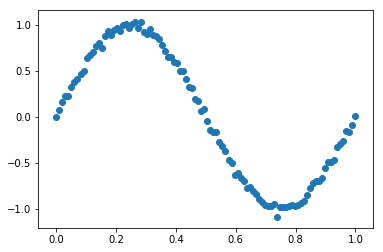

In [89]:
x, t = generateDataset(100, lambda a: np.sin(2*np.pi*a), 0.03)

plt.scatter(x, t)

### 2.2 Polynomial curve fitting
Given our dataset, we'll attempt to learn our function $y$. We assume that $y$ is a polynom of degree $m$. That is, $y(x)=w_{0}+w_{1}\cdot x+w_{2}\cdot x^{2}+...+w_{m}\cdot x^{m}$. We'll try to estimate the vector $\vec{w}=(w_{0},w_{1},w_{2},...,w_{m})$. We'll do that by optimizing the square error function. We'll define $E(w)=\frac{1}{2}\sum_{i=1}^{n}(y(x_{i})-t_{i})^2$. We'll try to minimize our error function. We'll calculate the partial derivatives for each $w_{i}$, and use them to find the minimum. We'll calculate:<br>
$\frac{\partial E}{\partial W_{i}}=0$<br>
We can convert these equations to a matrix form in order to solve them, and we receive that the optimal value $w_{LS}$ is:<br>
$w_{LS}=(\Phi^{T}\Phi)^{-1}\Phi^{T} t$

We'll implement a python method for finding the optimal value.

In [40]:
def getPhiMat(x: np.array, M: int) -> np.array:
    return np.array([[x_i**m for x_i in x] for m in range(M+1)], dtype='float64').T

def optimizeLS(x: np.array, t: np.array, M: int) -> np.array:
    mat = getPhiMat(x, M)
    inv = np.linalg.inv(np.dot(mat.T, mat))
    mat = np.dot(inv, mat.T)
    w = np.dot(mat, t)
    return w

Now we'll create a function that for a given value of $x$, and a vector $w$, will return the value $y(x)$, where $y(x)=w_{0}+w_{1}\cdot x+w_{2}\cdot x^{2}+...+w_{i}\cdot x^{i}$.

In [41]:
def polyFunc(x: float, W: np.array) -> float:
    return sum([w*(x**k) for k,w in enumerate(W)])

Now, let's draw a graph with our original function $sin(2\pi x)$, our dataset, which will contain 10 points, and also we'll draw our polynoms generated by our function for $M\in\{1,3,5,10\}$, where $M$ is the degree of the polynom.

In [163]:
def plot_results(x: np.array, t: np.array, m_val: List[int], func: Callable[[float],float]) -> None:
    plt.plot(np.linspace(0, 1, 100), np.sin(2*np.pi*np.linspace(0, 1, 100)))
    plt.scatter(x,t, s=90, color='lightBlue')
    for m in m_val:
        W = optimizeLS(x,t,m)
        y2 = [polyFunc(x_i,W) for x_i in x]
        plt.scatter(x,y2, marker='.')

    plt.legend(['$sin(2\pi x)$','Dataset'] + ['M={0}'.format(m) for m in m_val])


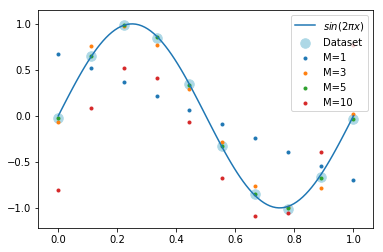

In [164]:
x, t = generateDataset(10, lambda a: np.sin(2*np.pi*a), 0.03)
plot_results(x,t,[1,3,5,10],lambda a: np.sin(2*np.pi*a))

We can see that for $M=1$ we got a linear function that didn't approximate our noisy function well, for $M=3$ we got a pretty good approximation. For $M=5$ our approximation follows very closely our noisy function, and for $M=10$ we got a pretty bad result, which I believe is a result of a floating point calculation, which got a value too low. We'll try this experiment again, this time with $M\in\{1,3,5,9\}$ and with a bit more noise, so we could observe our overfitting better.

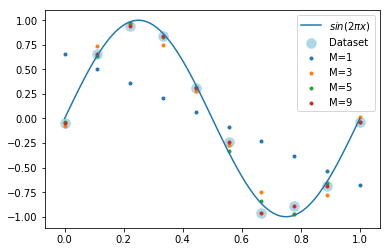

In [166]:
x, t = generateDataset(10, lambda a: np.sin(2*np.pi*a), 0.06)
plot_results(x,t,[1,3,5,9],lambda a: np.sin(2*np.pi*a))

We can see here that for $M=9$ our polynom follows our dataset closely, and is no longer a good approximation of the $sin(2\pi x)$ function. That overfitting could perhaps be solved with regularization.

### 2.3 Polynomial curve fitting with regularization

To overcome our overfitting, we can change our error function. Now, not only we will take into account our least squares error function, but we will also introduce to the error function a penalty for the complexity of the model.
Our new error function will be $E_{PLS}(W)=E(W)+\lambda\cdot E_{W}(W)$. Where $E(W)$ is our least squares error function, and $E_{W}(W)$ will be $E_{W}(W)=\frac{1}{2}w^{T}\cdot w$. The more complex our model will be, that is - the more entries in $w$ which will have high values, our model will be penalized more. That way, when finding the optimal model we will find not only the one with the minimal least squares, but also the one which will be the "smoothest".
In matrix form, we can solve this by finding $W_{PLS}=(\Phi^{T}\Phi+\lambda I)^{-1}\Phi^{T} t$.

In order to pick the best value for $\lambda$, we will split our dataset to training, validation, and test data. We will train on our training data, and we'll try to pick the best value for $\lambda$ using our validation data. How? We will calculate the normalized error function on the validation data, on different values of $\lambda$, and we'll find the one that would give us the smallest normalized error.
The normalized error is defined as: $NE_{w}(x,t)=\frac{1}{N}\sqrt{\sum_{i=1}^{N}(t_{i}-y(x_{i}))^{2}}$

First, let's create the function that would create our dataset for us, divided to training, validation and test. Our function will divide the interval $[0,1]$ to three sets, and would apply the function $f$ with the noise, to them.

In [38]:
def generate3Dataset(N: int, f: Callable[[float], float], sigma: float) -> Tuple[Tuple[np.array]]:
    x = np.linspace(0, 1, num=3*N)
    np.random.shuffle(x)
    x_parts = [[x[i] for i in range(N*j, N*(j+1))] for j in range(3)]
    x_parts = [sorted(part) for part in x_parts]
    t_parts = [[f(i) + np.random.normal(loc=0.0, scale=sigma) for i in part] for part in x_parts]
    ans = [(x_parts[i], t_parts[i]) for i in range(3)]
    return tuple(ans)

We need to create our function for optimizing the PLS, let's write it. It would work very similiar to the optimizeLS function, but we'll also receive a $\lambda$ value and we'll use it to apply regularization.

In [175]:
def optimizePLS(x: np.array, t: np.array, M: int, l: float) -> np.array:
    mat = np.array([[x_i**m for x_i in x] for m in range(M+1)], dtype='float64')
    mat = mat.T
    prod = np.dot(mat.T, mat)
    prod = prod + l*np.identity(M+1)
    i = np.linalg.inv(prod)
    mat = np.dot(i, mat.T)
    w = np.dot(mat, t)
    return w

Let's now create a function for calculating the normalized error.

In [227]:
def normErr(x: np.array, t: np.array, W: np.array) -> float:
    N = len(x)
    s = sum([(t[i]-polyFunc(x[i],W))**2 for i in range(N)])
    return np.sqrt(s)/N


We'll use our function for calculating the normalized error, for finding our optimal value of $\lambda$. We'll train our model using different values of $\lambda$, and we'll pick the one with the smallest normalized error on the validation data.

In [286]:
lambdaRange = [np.exp(logLambda) for logLambda in range(-40,-20)]

def getErrList(xt: np.array, tt: np.array, xv: np.array, tv: np.array, M: int) -> float:
    errVal = []
    for lambdaVal in lambdaRange:
        curr_w = optimizePLS(xt, tt, M, lambdaVal)
        errVal.append((normErr(xv, tv, curr_w), lambdaVal))
    return errVal

def optimizePLSLambda(xt: np.array, tt: np.array, xv: np.array, tv: np.array, M: int) -> float:
    errVal = getErrList(xt, tt, xv, tv, M)
    return min(errVal)[1]

Let's start first by creating our dataset for $N=10$, and see our results.

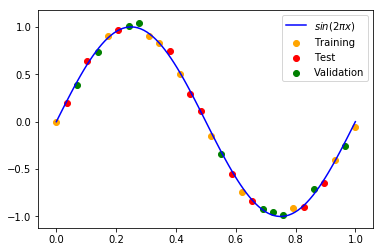

In [333]:
def scatterData(train_x, train_t, test_x, test_t, valid_x, valid_t) -> None:
    plt.scatter(train_x, train_t, c='orange')
    plt.scatter(test_x, test_t, c='red')
    plt.scatter(valid_x, valid_t, c='green')
    plt.plot(np.linspace(0,1,100),np.sin(2*np.pi*np.linspace(0,1,100)), c='blue')
    plt.legend(['$sin(2\pi x)$','Training','Test','Validation'])

(train_x, train_t),(test_x, test_t), (valid_x, valid_t) = generate3Dataset(10, lambda a:np.sin(2*np.pi*a), 0.03)
scatterData(train_x, train_t, test_x, test_t, valid_x, valid_t)

Let's now measure the normalized error on the training, test and validation data for different values of $\lambda$.

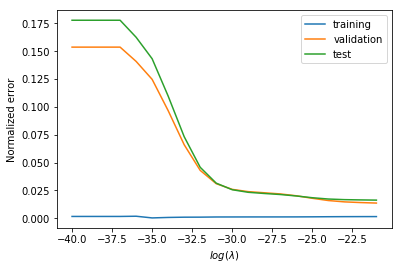

In [334]:
def plotErrors(m_val, train_x, train_t, valid_x, valid_t, test_x, test_t) -> None:
    errListTrain = [elem[0] for elem in getErrList(train_x, train_t, train_x, train_t, m_val)]
    errListValid = [elem[0] for elem in getErrList(train_x, train_t, valid_x, valid_t, m_val)]
    errListTest = [elem[0] for elem in getErrList(train_x, train_t, test_x, test_t, m_val)]
    errLists = [errListTrain, errListValid, errListTest]
    for errList in errLists:
        plt.plot(np.log(lambdaRange), errList)
    plt.ylabel('Normalized error')
    plt.xlabel('$log(\lambda)$')
    plt.legend(['training', 'validation', 'test'])

m_val = 9
plotErrors(m_val, train_x, train_t, valid_x, valid_t, test_x, test_t)

We can see that the normalized error on the training data is low from the begining. That makes sense since that's the data on which we believe there's overfitting. For small values of $\lambda$ the normalized error on the validation and test data is quite high. But decreases as we increase the value of $\lambda$. Let's see now how the plot looks with the optimal value of $\lambda$.

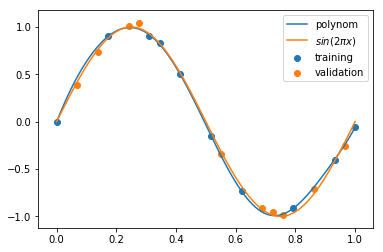

In [336]:
def plotOptimize(train_x, train_t, valid_x, valid_t, m_val) -> None:
    lambda_opt = optimizePLSLambda(train_x, train_t, valid_x, valid_t, m_val)
    w_reg = optimizePLS(train_x, train_t, m_val, lambda_opt)
    plt.plot(np.linspace(0,1,100), [polyFunc(x_i, w_reg) for x_i in np.linspace(0,1,100)])
    plt.scatter(train_x, train_t)
    plt.scatter(valid_x, valid_t)
    plt.plot(np.linspace(0,1,100),np.sin(2*np.pi*np.linspace(0,1,100)))
    plt.legend(['polynom', '$sin(2\pi x)$', 'training', 'validation'])

plotOptimize(train_x, train_t, valid_x, valid_t, m_val)

Let's now observe the same graphs for $N=100$.

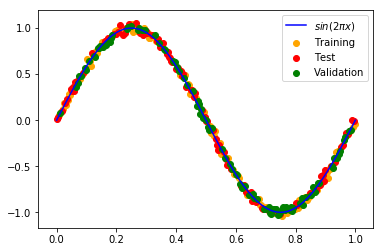

In [338]:
(train_x, train_t),(test_x, test_t), (valid_x, valid_t) = generate3Dataset(100, lambda a:np.sin(2*np.pi*a), 0.03)
scatterData(train_x, train_t, test_x, test_t, valid_x, valid_t)

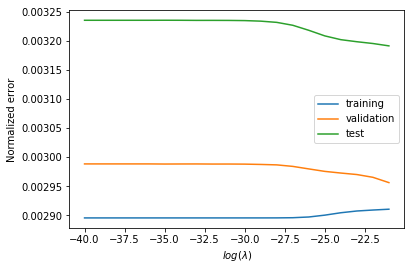

In [339]:
plotErrors(m_val, train_x, train_t, valid_x, valid_t, test_x, test_t)

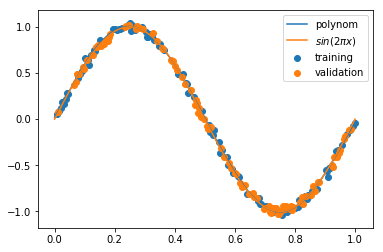

In [340]:
plotOptimize(train_x, train_t, valid_x, valid_t, m_val)

We can see that we have more data, we have less need for regularization. That is probably because a large dataset is more representative. We can see that the normalized error is very small for all values of $\lambda$, and while it slightly lower on the training data, we can observe that even without regularization we could've obtained pretty good results.

### 2.4 Proabilistic regression framework
This time, instead of estimating using maximum likelihood to find an optimal value for $w$, we will use bayesian estimation, as we've seen that maximum likelihood can cause overfitting. We will calculate two functions $m(x)$ and $v(x)$ which will be our estimation for the distribution in a given point $x$.

In [57]:
def bayesianEstimator(x: np.array, t: np.array, M: int, alpha: float, sigma2: float) -> Tuple[Callable, Callable]:
    rowVecMat = getPhiMat(x, M)
    s_inverse = alpha*np.identity(M+1) + (1/sigma2)*sum([np.outer(rowVecMat[i], rowVecMat[i].T) for i in range(len(x))])
    s = np.linalg.inv(s_inverse)
    
    def mean(curr_x: float) -> float:
        ans = sum([rowVecMat[i]*t[i] for i in range(len(x))])
        ans = np.dot(s, ans)
        ans = np.dot(np.array([curr_x**m for m in range(M+1)]), ans)
        ans = ans * (1/sigma2)
        return ans
    
    def variance(curr_x: float) -> float:
        ans = np.dot(s, np.array([curr_x**m for m in range(M+1)]))
        ans = np.dot(np.array([curr_x**m for m in range(M+1)]).T, ans)
        return sigma2 + ans
    
    return mean, variance

Next, we'll create a function for plotting the mean function calculated, and the confidence interval around it. Which will be one standard deviation in each direction.

In [54]:
alpha = 0.005
sigma2 = 1/11.1
M = 9
def plotBayesian(N: int) -> None:
    (train_x, train_t),(test_x, test_t), (valid_x, valid_t) = generate3Dataset(N, lambda a:np.sin(2*np.pi*a), 0.03)
    m ,v = bayesianEstimator(train_x, train_t, M, alpha, sigma2)
    x_vals = np.linspace(0, 1, 100)
    plt.scatter(train_x, train_t, marker='.')
    plt.plot(x_vals, np.sin(2*np.pi*x_vals))
    plt.plot(x_vals, [m(x) for x in x_vals])
    plt.fill_between(x_vals,[m(x)-np.sqrt(v(x)) for x in x_vals],[m(x)+np.sqrt(v(x)) for x in x_vals], alpha=0.4, color='r')
    plt.legend(['$sin(2\pi x)$','mean','Training data','confidence interval'])

Let's see the plot first for $N=100$.

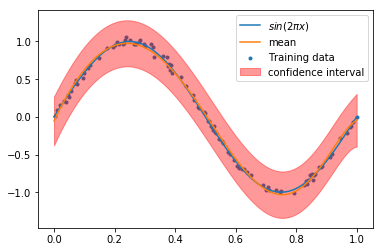

In [55]:
plotBayesian(100)

We can see that our mean is very close to the actual function, and that the variance is relatively constant around our mean. Let's try now for $N=10$.

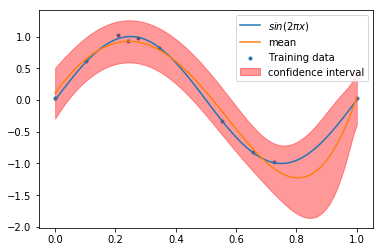

In [68]:
plotBayesian(10)

As expected, since we have less data, our mean follows our original function less closely, especially in places where there is no data. Also noticable is the fact that on those places the variance is large, indicating that the model is less sure about the median in those places.